In [53]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import json
import numpy as np
from pathlib import Path
import h5py
import scipy.stats
import torch
import pandas as pd
import os

import bnn_priors.plot as plot
import bnn_priors.exp_utils as exp_utils
import seaborn as sns
from bnn_priors.notebook_utils import flatten, unique_cols, collect_runs


%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

In [2]:

base_log_dir = Path("/scratches/huygens/ag919/BNN-priors/logs/0_51_integrators_cifar")

series_list = []

for run in os.listdir(base_log_dir):
    if run in ["_sources", "jugdir"]:
        continue
    if not os.path.exists(base_log_dir/run/"samples.pt"):
        continue
    try:
        with open(base_log_dir/run/"run.json") as f:
            s2 = pd.Series(flatten(json.load(f)))
        with open(base_log_dir/run/"config.json") as f:
            s1 = pd.Series(flatten(json.load(f)))

        s2["the_dir"] = base_log_dir/run
        series_list.append(pd.concat([s1, s2]))
    except json.JSONDecodeError as e:
        print(run, e)
    except FileNotFoundError as e:
        print(run, e)
        
    
full_df = pd.DataFrame(series_list)
full_df[["status", "lr", "temperature", "weight_prior", "inference", "log_dir", "load_samples"]]

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if sys.path[0] == '':


,status,lr,temperature,weight_prior,inference,log_dir,load_samples
0,COMPLETED,0.100000,1.00,gaussian,VerletSGLDReject,/scratches/huygens/ag919/BNN-priors/logs/0_51_...,/scratches/huygens/ag919/BNN-priors/logs/0_51_...
1,COMPLETED,0.000100,0.01,gaussian,SGLD,/scratches/huygens/ag919/BNN-priors/logs/0_51_...,/scratches/huygens/ag919/BNN-priors/logs/0_51_...
2,COMPLETED,0.000001,1.00,gaussian,HMCReject,/scratches/huygens/ag919/BNN-priors/logs/0_51_...,/scratches/huygens/ag919/BNN-priors/logs/0_51_...
3,COMPLETED,0.001000,1.00,gaussian,VerletSGLDReject,/scratches/huygens/ag919/BNN-priors/logs/0_51_...,None
4,FAILED,0.000001,1.00,gaussian,SGLD,/scratches/huygens/ag919/BNN-priors/logs/0_51_...,/scratches/huygens/ag919/BNN-priors/logs/0_51_...
...,...,...,...,...,...,...,...
87,COMPLETED,0.100000,1.00,gaussian,HMCReject,/scratches/huygens/ag919/BNN-priors/logs/0_51_...,/scratches/huygens/ag919/BNN-priors/logs/0_51_...
88,RUNNING,0.000001,1.00,gaussian,SGLD,/scratches/huygens/ag919/BNN-priors/logs/0_51_...,/scratches/huygens/ag919/BNN-priors/logs/0_51_...
89,FAILED,0.001000,0.01,gaussian,VerletSGLDReject,/scratches/huygens/ag919/BNN-priors/logs/0_51_...,None
90,COMPLETED,0.001000,1.00,gaussian,VerletSGLDReject,/scratches/huygens/ag919/BNN-priors/logs/0_51_...,None


In [3]:
def metrics_exist(the_dir):
    return os.path.exists(os.path.join(the_dir, "metrics.h5"))

inference = "SGLD"
temperature = 1.0
#fig.suptitle(f"Preresnet18, on CIFAR-10 with data augmentation")


completed_df = full_df[(full_df["weight_prior"] == "gaussian") 
                       & (full_df["temperature"] == temperature)
                       & (full_df["inference"] == inference)
                       & (full_df["lr"] != 0.1)
                       & (full_df["cycles"] == 300)
                       & (full_df["the_dir"].apply(metrics_exist))]
completed_df[unique_cols(completed_df)]

,load_samples,lr,momentum,seed
4,/scratches/huygens/ag919/BNN-priors/logs/0_51_...,0.000001,0.999936,524192603.0
11,/scratches/huygens/ag919/BNN-priors/logs/0_51_...,0.000001,0.999936,122023638.0
20,None,0.000001,0.999936,556736590.0
22,None,0.010000,0.993632,72900599.0
32,/scratches/huygens/ag919/BNN-priors/logs/0_51_...,0.000100,0.999361,722899275.0
34,/scratches/huygens/ag919/BNN-priors/logs/0_51_...,0.010000,0.993632,427499812.0
57,/scratches/huygens/ag919/BNN-priors/logs/0_51_...,0.001000,0.997982,613197384.0
63,None,0.000100,0.999361,107331205.0
73,None,0.001000,0.997982,684863689.0
84,/scratches/huygens/ag919/BNN-priors/logs/0_51_...,0.000001,0.999936,100575106.0


In [4]:
full_df = full_df[full_df["status"] != "FAILED"]
full_df[["status", "lr", "temperature", "weight_prior", "inference", "the_dir", "load_samples", "sampling_decay"]][full_df["sampling_decay"] == "stairs2"].loc[
    30, "the_dir"]

KeyError: 30

## Create model class

First we create the model class used in the run. Used in the metrics to know the sizes of the parameters.

In [5]:
with open(Path(full_df.iloc[0, :]["the_dir"])/"config.json", "r") as f:
    config = json.load(f)

device = torch.device("cpu")  # can be CUDA instead
data = exp_utils.get_data(config["data"], device)
model = exp_utils.get_model(x_train=data.norm.train_X, y_train=data.norm.train_y,
                            **{k: v for k, v in config.items() if k in set((
                               "model",
                               "width", "depth", "weight_prior", "weight_loc", "weight_scale",
                               "bias_prior", "bias_loc", "bias_scale", "batchnorm",
                               "weight_prior_params", "bias_prior_params"))})

print(f"Loaded model of kind {config['model']}")
config["temperature"]

Loaded model of kind googleresnet


1.0

In [6]:
config["temperature"], config["lr"]

(1.0, 0.1)

In [7]:
sizes = plot.get_sizes(model)


## Plot metrics

First we load the metrics, then we plot various aspects of them.

In [11]:
full_df.loc[[23, 37], ["the_dir"]].values

array([[PosixPath('/scratches/huygens/ag919/BNN-priors/logs/0_51_integrators_cifar/43')],
       [PosixPath('/scratches/huygens/ag919/BNN-priors/logs/0_51_integrators_cifar/85')]],
      dtype=object)

In [12]:
full_df[["inference", "temperature", "lr", "momentum"]].sort_values(by=["inference", "temperature", "lr", "momentum"])

,inference,temperature,lr,momentum
2,HMCReject,1.0,0.000001,1.00
9,HMCReject,1.0,0.000001,1.00
29,HMCReject,1.0,0.000100,1.00
71,HMCReject,1.0,0.000100,1.00
34,HMCReject,1.0,0.001000,1.00
...,...,...,...,...
57,NaN,0.0,0.100000,0.00
13,NaN,0.0,0.100000,0.90
30,NaN,0.0,0.100000,0.90
21,NaN,0.0,0.100000,0.98


[0.86 0.87 0.88 0.88 0.88 0.88 0.86 0.89 0.88 0.91 0.86 0.88 0.87 0.87
 0.88 0.88 0.87 0.89 0.88 0.89 0.88 0.89 0.89 0.88 0.87 0.88 0.88 0.89
 0.89 0.88 0.89 0.89 0.89 0.87 0.87 0.87 0.88 0.88 0.87 0.88 0.89 0.88
 0.88 0.87 0.89 0.88 0.86 0.88 0.87 0.88]


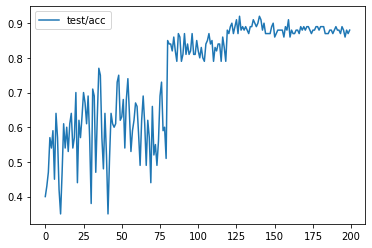

In [53]:

with h5py.File("/scratches/huygens/ag919/BNN-priors/logs/0_51_integrators_cifar/81/metrics.h5", 'r', swmr=True) as metrics:
    plot.metric(plt, metrics, "test/acc", mask=slice(None), legend=True)
    print(metrics["test/acc"][-50:])

SGD m=0.9 0.8930000000000001
SGD mom 0.9209999999999999
SGD Unable to open file (truncated file: eof = 48, sblock->base_addr = 0, stored_eof = 2048)


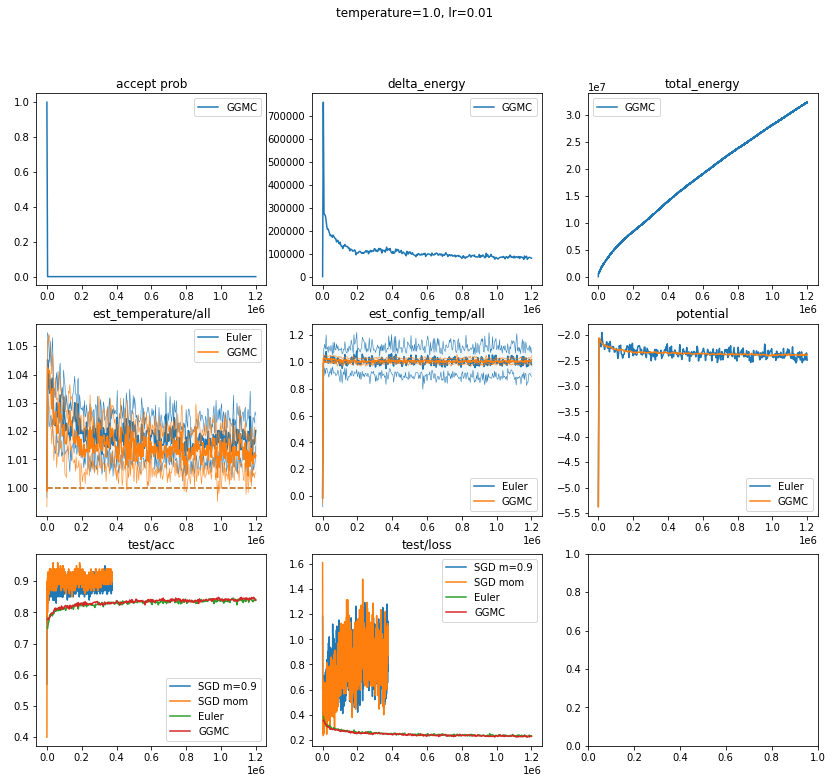

In [54]:
fig, axes = plt.subplots(3, 3, figsize=(14, 12), facecolor='white')


temperature = 1.0
lr = 0.01

def accept_prob(x):
    return np.exp(np.minimum(0., -x/temperature))


df = full_df[(full_df["lr"] == lr) 
             & (full_df["temperature"] == temperature)]

sgd_df = full_df[(full_df["lr"] == lr)
                & (full_df["temperature"] == 0.0 )]

fig.suptitle(f"temperature={temperature}, lr={lr}")
for completed_df, label in [
    (sgd_df[(sgd_df["momentum"] == 0.9)], "SGD m=0.9"),
    (sgd_df[(sgd_df["momentum"] > 0.9)], "SGD mom"),
    (sgd_df[(sgd_df["momentum"] == 0.0)], "SGD"),
    (df[(df["inference"] == "SGLD") & ~df["load_samples"].isna()], "Euler"),
    #(df[df["inference"] == "HMCReject"], "HMC"),
    (df[(df["inference"] == "VerletSGLDReject") & ~df["load_samples"].isna()], "GGMC"),]:
    #if 0.1 != completed_df.loc[idx, "lr"]:
    #    continue
    plot_kwargs = dict(label=label)
    
    try:
        log_dir = completed_df["the_dir"].iloc[-1]
    except IndexError:
        continue
    try:
        metrics = h5py.File(Path(log_dir, "metrics.h5"), "r", swmr=True)
        if "acceptance" in metrics:
            is_sample_mask = (metrics['acceptance/is_sample'][:] == 1)
        else:
            is_sample_mask = slice(None)
        if "delta_energy" in metrics:
            ax = axes[0, 0]
            plot.metric(ax, metrics, "delta_energy", transform=accept_prob,
                        plot_kwargs=plot_kwargs, mask=is_sample_mask, legend=True)
            ax.set_title("accept prob")

            ax = axes[0, 1]
            plot.metric(ax, metrics, "delta_energy", mask=is_sample_mask, ewma_alpha=0.0, iqr_ylim=None,
                       plot_kwargs=plot_kwargs, legend=True)
            ax.set_title("delta_energy")

            #plot.vlines(axes[1], metrics, is_sample_mask)
            ax = axes[0, 2]
            plot.metric(ax, metrics, "total_energy", mask=slice(None), iqr_ylim=None, plot_kwargs=plot_kwargs, legend=True)
            ax.set_title("total_energy")
        if "est_temperature" in metrics:
            ax = axes[1, 0]
            plot.temperature_stderr(ax, metrics, "est_temperature", sizes, mask=is_sample_mask, legend=True, label=label)
            ax.set_title("est_temperature/all")

            ax = axes[1, 1]
            plot.temperature_stderr(ax, metrics, "est_config_temp", sizes, mask=is_sample_mask, legend=True, label=label)
            ax.set_title("est_config_temp/all")


            ax = axes[1, 2]
            plot.metric(ax, metrics, "potential", mask=is_sample_mask, plot_kwargs=plot_kwargs, legend=True)
            ax.set_title("potential")
        
            ax = axes[2, 0]
            plot.metric(ax, metrics, "test/acc", mask=is_sample_mask, plot_kwargs=dict(label=label), legend=True)
            ax.set_title("test/acc")

            ax = axes[2, 1]
            plot.metric(ax, metrics, "test/loss", mask=is_sample_mask, plot_kwargs=plot_kwargs, legend=True)
            ax.set_title("test/loss")
        else:
            ax = axes[2, 0]
            ax.plot(metrics["steps"][:] * 125, metrics["test/acc"][:],  label=label)
            ax.set_title("test/acc")
            print(label, metrics["test/acc"][-10:].mean())
            
            ax = axes[2, 1]
            ax.plot(metrics["steps"][:] * 125, metrics["test/loss"][:], label=label)
            ax.set_title("test/loss")

    except OSError as e:
        print(label, e)
    finally:
        metrics.close()

axes[2, 1].legend()
axes[2, 0].legend()
                
#axes[0, 1].set_ylim(-10, 40000)
#axes[0, 2].set_ylim(-10, 10000000)
#if temperature == 1.0:
#    axes[1, 0].set_ylim(0.975, 1.025)
#    axes[1, 1].set_ylim(0.975, 1.025)
#elif temperature == 0.01:
#    axes[1, 0].set_ylim(0.005, 0.02)
#    axes[1, 1].set_ylim(0.004, 0.02)
#axes[2, 0].set_ylim((0.75, 1.0))

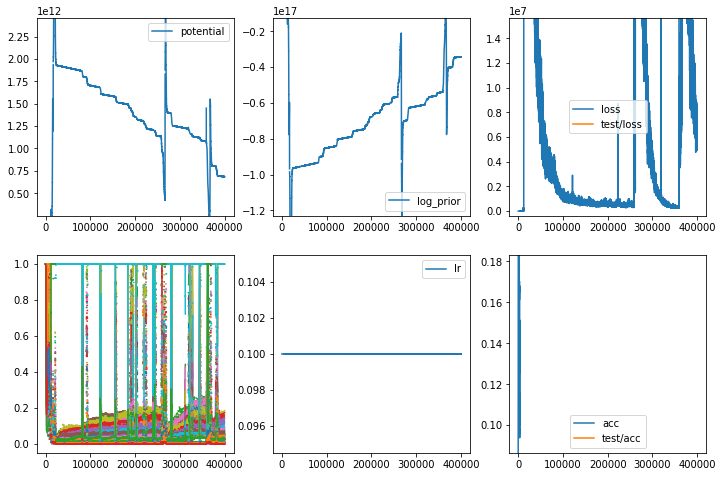

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

mask = slice(None)

plot.metric(axes[0, 0], metrics, 'potential', iqr_ylim=2., mask=mask)
plot.metric(axes[0, 1], metrics, 'log_prior', iqr_ylim=2., mask=mask)

test_mask = ~np.isnan(metrics["test/loss"])

plot.metric(axes[0, 2], metrics, 'loss', mask=mask, iqr_ylim=2.)
plot.metric(axes[0, 2], metrics, 'test/loss', mask=mask)

for k in metrics["preconditioner"].keys():
    plot.metric(axes[1, 0], metrics, "preconditioner/"+k, mask=mask, legend=False)

plot.metric(axes[1, 1], metrics, 'lr', mask=mask)

plot.metric(axes[1, 2], metrics, 'acc', mask=mask, iqr_ylim=2., ewma_alpha=0.9)
plot.metric(axes[1, 2], metrics, 'test/acc', mask=mask, iqr_ylim=2.)

In [14]:
"average acceptance", 1-np.mean(metrics["acceptance/rejected"][mask])

('average acceptance', 9.178023947533842e+18)

In [16]:
mcmc_burnin = 0

state_dict_samples = exp_utils.load_samples(log_dir/"samples.pt", idx=np.s_[mcmc_burnin:])
if config["reject_samples"]:
    # Making sure that rejected samples have the same value as the previous one
    print("made sure of rejected samples")
    exp_utils.reject_samples_(state_dict_samples, metrics)


## Load and poke the model

In [17]:
del state_dict_samples["steps"]
del state_dict_samples["timestamps"]

if device == torch.device("cpu") and config["device"] != "cpu":
    # HACK: get around the lack of `nn.DataParallel` when loading on CPU:
    # *remove* .module. from the key
    for k in list(state_dict_samples.keys()):
        if k.startswith("net.module."):
            state_dict_samples["net." + k.lstrip("net.module.")] = state_dict_samples[k]
            del state_dict_samples[k]

In [18]:
model.load_state_dict({k: v[-1] for k, v in state_dict_samples.items()})

<All keys matched successfully>

# Figures for aabi paper 

No handles with labels found to put in legend.
No handles with labels found to put in legend.


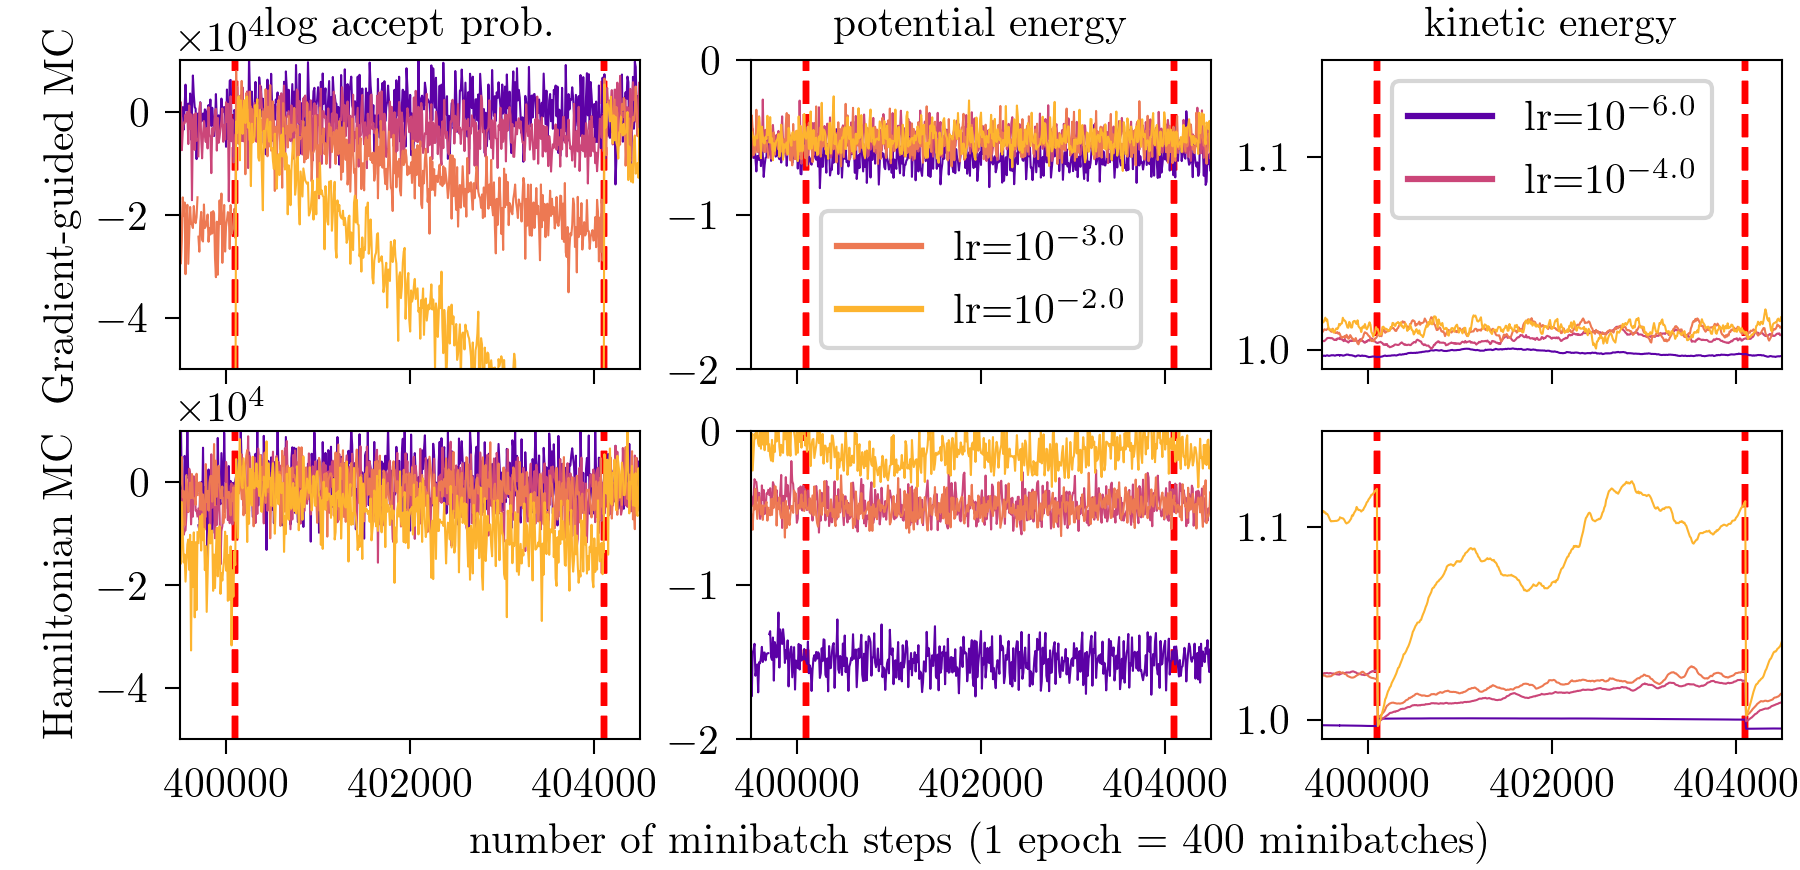

In [50]:

plt.rcParams.update({
    "axes.linewidth": 0.5,
    'ytick.major.width': 0.5,
    'xtick.major.width': 0.5,
    'ytick.minor.width': 0.5,
    'xtick.minor.width': 0.5,
    "figure.dpi": 300,
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False
})

fig_width_pt = 433.62
inches_per_pt = 1.0/72.27               # Convert pt to inches
fig_width = fig_width_pt*inches_per_pt  # width in inches

fig, all_axes = plt.subplots(2, 3, figsize=(fig_width, fig_width/8.27*4), gridspec_kw=dict(
    bottom=0.15, left=0.1, right=0.99, top=0.93, hspace=0.2, wspace=0.24), facecolor='white')

import matplotlib
import math
labelsize= matplotlib.rcParams['axes.labelsize']

def log_accept_prob(x):
    return -x/temperature

def metrics_exist(the_dir):
    return os.path.exists(os.path.join(the_dir, "metrics.h5"))

inference = "VerletSGLDReject"
temperature = 1.0
#fig.suptitle(f"Preresnet18, on CIFAR-10 with data augmentation")


completed_df = full_df[(full_df["weight_prior"] == "gaussian") 
                       & (full_df["temperature"] == temperature)
                       & (full_df["inference"] == inference)
                       & (full_df["lr"] != 0.1)
                       & (full_df["cycles"] == 300)
                       & (full_df["load_samples"].isna())
                       & (full_df["the_dir"].apply(metrics_exist))]

min_log_lr = math.log(full_df["lr"].min(), 10) - 1
max_log_lr = math.log(full_df["lr"].max(), 10)
_cmap = plt.get_cmap('plasma')

def lr_cmap(log_lr):
    x = (log_lr - min_log_lr) / (max_log_lr- min_log_lr)
    return _cmap(x)
    


axes = all_axes[0]
for i_order, idx in enumerate(completed_df.sort_values("lr").index):
    log_lr = round(math.log(completed_df.loc[idx, 'lr'], 10)*10) / 10
    
    color_kwargs = dict(color=lr_cmap(log_lr), alpha=1)
    #color_kwargs = dict(color="C1", alpha=1)
    plot_kwargs = dict(**color_kwargs, label=None, linewidth=0.5)
    label=f"$\ell=10^{{{int(log_lr)}}}$"
    
    with h5py.File(Path(completed_df.loc[idx, "the_dir"], "metrics.h5"), "r", swmr=True) as metrics:
        is_sample_mask = (metrics['acceptance/is_sample'][:] == 1)
        #is_sample_mask = slice(None)
        ax = axes[0]
        plot.metric(ax, metrics, "delta_energy", transform=log_accept_prob,
                    plot_kwargs=plot_kwargs, mask=slice(None), legend=False)
        ax.set_title("\\hspace{2em}log accept prob.", fontsize=labelsize)
        plot.vlines(ax, metrics, is_sample_mask)
        
        ax = axes[1]
        plot.metric(ax, metrics, "potential", mask=slice(None), plot_kwargs=plot_kwargs, legend=False)
        ax.set_title("potential energy", fontsize=labelsize)
        plot.vlines(ax, metrics, is_sample_mask)
        if i_order >= 2:
            ax.plot([], [], **color_kwargs, label=label)
        ax.legend(loc='lower center')
        
        ax = axes[2]
        plot.metric(ax, metrics, "est_temperature/all", mask=slice(None), plot_kwargs=plot_kwargs, legend=False)
        ax.set_title("kinetic energy", fontsize=labelsize)
        plot.vlines(ax, metrics, is_sample_mask)
        if i_order < 2:
            ax.plot([], [], **color_kwargs, label=label)
        ax.legend(loc='upper center')
            
axes[0].set_ylabel("Gradient-guided MC")

        
inference = "HMCReject"
temperature = 1.0
cmap = plt.get_cmap('plasma')

completed_df = full_df[(full_df["weight_prior"] == "gaussian") 
                       & (full_df["temperature"] == temperature)
                       & (full_df["inference"] == inference)
                       & (full_df["lr"] != 0.1)
                       & (full_df["cycles"] == 300)
                       & (full_df["load_samples"].isna())
                       & (full_df["the_dir"].apply(metrics_exist))]

axes = all_axes[1]
for i_order, idx in enumerate(completed_df.sort_values("lr").index):
    log_lr = round(math.log(completed_df.loc[idx, 'lr'], 10)*10) / 10
    
    color_kwargs = dict(color=lr_cmap(log_lr), alpha=1)
    #color_kwargs = dict(color="C1", alpha=1)
    plot_kwargs = dict(label=f"$\\log_{{10}} \\ell={{{log_lr}}}$", **color_kwargs, linewidth=0.5)
    
    with h5py.File(Path(completed_df.loc[idx, "the_dir"], "metrics.h5"), "r", swmr=True) as metrics:
        is_sample_mask = (metrics['acceptance/is_sample'][:] == 1)
        #is_sample_mask = slice(None)
        ax = axes[0]
        plot.metric(ax, metrics, "delta_energy", transform=log_accept_prob,
                    plot_kwargs=plot_kwargs, mask=slice(None), legend=False)
        #ax.set_title("log accept prob.")
        plot.vlines(ax, metrics, is_sample_mask)
        
        ax = axes[1]
        plot.metric(ax, metrics, "potential", mask=slice(None), plot_kwargs=plot_kwargs, legend=False)
        #ax.set_title("potential")
        plot.vlines(ax, metrics, is_sample_mask)
        
        ax = axes[2]
        plot.metric(ax, metrics, "est_temperature/all", mask=slice(None), plot_kwargs=plot_kwargs, legend=False)
        #ax.set_title("est_temperature/all")
        plot.vlines(ax, metrics, is_sample_mask)
axes[0].set_ylabel("Hamiltonian MC")

for ax in all_axes[0]:
    ax.set(xticklabels=[])

for axes in all_axes:
    axes[0].set_ylim((-50000, 10000))
    axes[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    axes[0].set_xlim((399500, 404500))
    axes[1].set_ylim((-2, 0))
    axes[1].set_xlim((399500, 404500))
    axes[2].set_ylim((0.99, 1.15))
    axes[2].set_xlim((399500, 404500))
    
all_axes[1, 1].set_xlabel("number of minibatch steps (1 epoch = 400 minibatches)")
fig.savefig("../figures/mcmc/accept_prob_googleresnet_cifar10.pgf")

No handles with labels found to put in legend.
No handles with labels found to put in legend.
/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/ipykernel_launcher.py:127: UserWarning: FixedFormatter should only be used together with FixedLocator


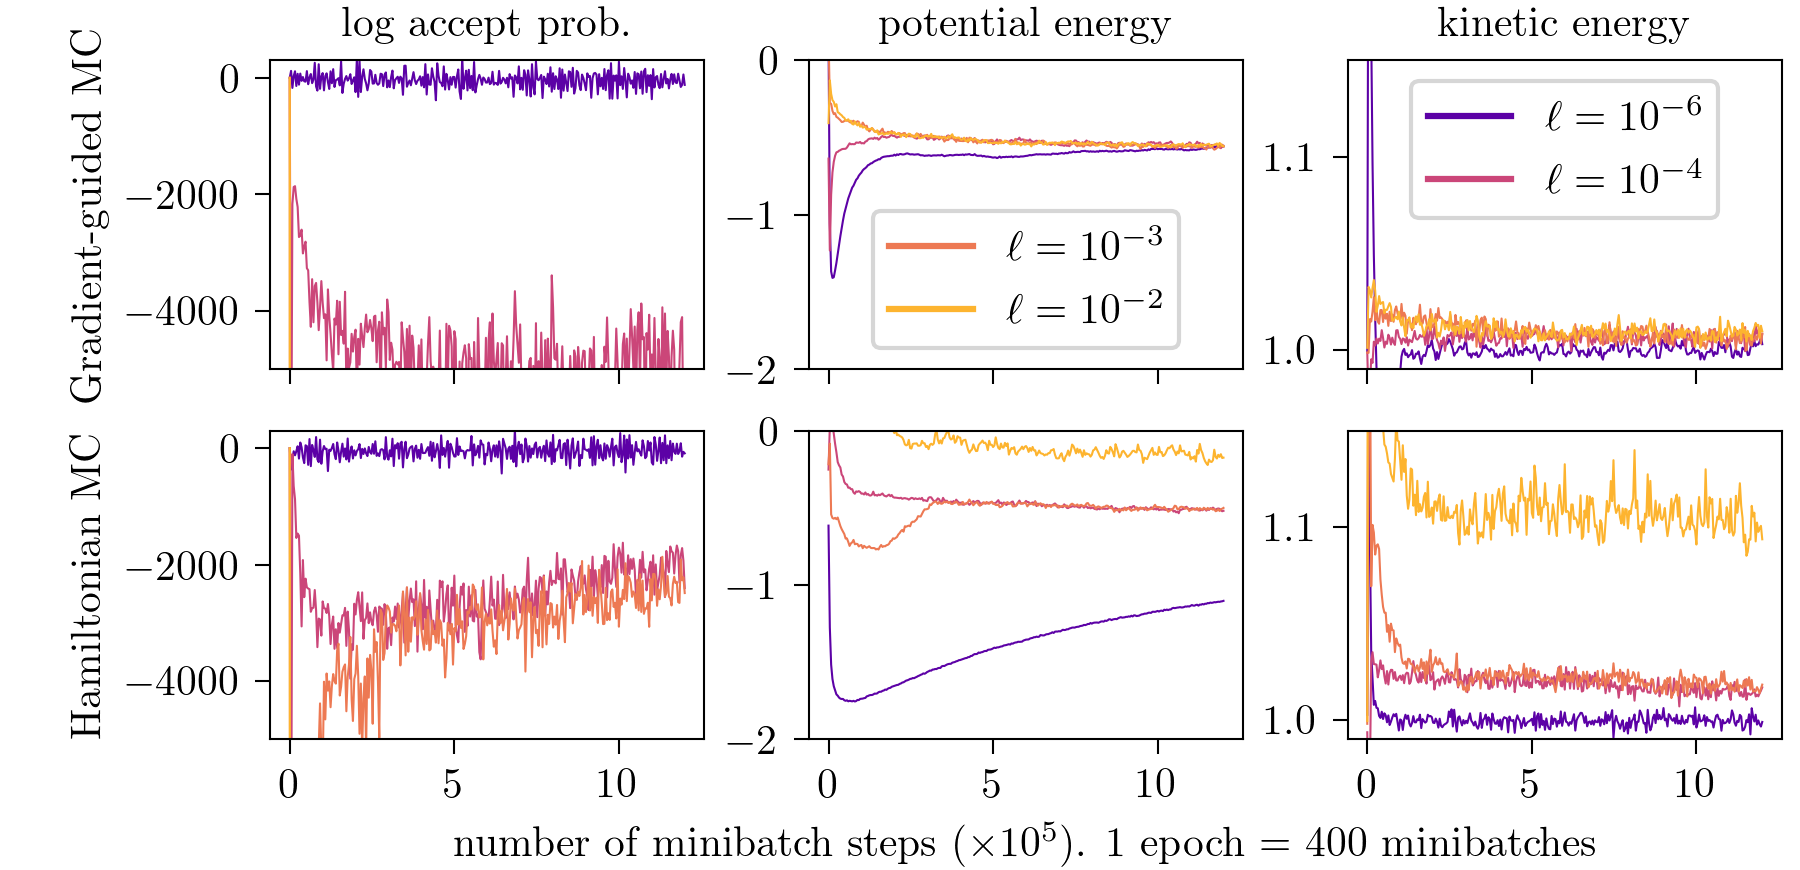

In [69]:

plt.rcParams.update({
    "axes.linewidth": 0.5,
    'ytick.major.width': 0.5,
    'xtick.major.width': 0.5,
    'ytick.minor.width': 0.5,
    'xtick.minor.width': 0.5,
    "figure.dpi": 300,
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False
})

fig_width_pt = 433.62
inches_per_pt = 1.0/72.27               # Convert pt to inches
fig_width = fig_width_pt*inches_per_pt  # width in inches

fig, all_axes = plt.subplots(2, 3, figsize=(fig_width, fig_width/8.27*4), gridspec_kw=dict(
    bottom=0.15, left=0.15, right=0.99, top=0.93, hspace=0.2, wspace=0.24), facecolor='white')

import matplotlib
import math
labelsize= matplotlib.rcParams['axes.labelsize']

def log_accept_prob(x):
    return -x/temperature

def metrics_exist(the_dir):
    return os.path.exists(os.path.join(the_dir, "metrics.h5"))

inference = "VerletSGLDReject"
temperature = 1.0
#fig.suptitle(f"Preresnet18, on CIFAR-10 with data augmentation")


completed_df = full_df[(full_df["weight_prior"] == "gaussian") 
                       & (full_df["temperature"] == temperature)
                       & (full_df["inference"] == inference)
                       & (full_df["lr"] != 0.1)
                       & (full_df["cycles"] == 300)
                       & (full_df["load_samples"].isna())
                       & (full_df["the_dir"].apply(metrics_exist))]

min_log_lr = math.log(full_df["lr"].min(), 10) - 1
max_log_lr = math.log(full_df["lr"].max(), 10)
_cmap = plt.get_cmap('plasma')

def lr_cmap(log_lr):
    x = (log_lr - min_log_lr) / (max_log_lr- min_log_lr)
    return _cmap(x)
    


axes = all_axes[0]
for i_order, idx in enumerate(completed_df.sort_values("lr").index):
    log_lr = round(math.log(completed_df.loc[idx, 'lr'], 10)*10) / 10
    
    color_kwargs = dict(color=lr_cmap(log_lr), alpha=1)
    #color_kwargs = dict(color="C1", alpha=1)
    plot_kwargs = dict(**color_kwargs, label=None, linewidth=0.5)
    label=f"$\ell=10^{{{int(log_lr)}}}$"
    
    with h5py.File(Path(completed_df.loc[idx, "the_dir"], "metrics.h5"), "r", swmr=True) as metrics:
        is_sample_mask = (metrics['acceptance/is_sample'][:] == 1)
        #is_sample_mask = slice(None)
        ax = axes[0]
        plot.metric(ax, metrics, "delta_energy", transform=log_accept_prob,
                    plot_kwargs=plot_kwargs, mask=is_sample_mask, legend=False)
        ax.set_title("\\hspace{2em}log accept prob.", fontsize=labelsize)
        
        ax = axes[1]
        plot.metric(ax, metrics, "potential", mask=is_sample_mask, plot_kwargs=plot_kwargs, legend=False)
        ax.set_title("potential energy", fontsize=labelsize)
        if i_order >= 2:
            ax.plot([], [], **color_kwargs, label=label)
        ax.legend(loc='lower center')
        
        ax = axes[2]
        plot.metric(ax, metrics, "est_temperature/all", mask=is_sample_mask, plot_kwargs=plot_kwargs, legend=False)
        ax.set_title("kinetic energy", fontsize=labelsize)
        if i_order < 2:
            ax.plot([], [], **color_kwargs, label=label)
        ax.legend(loc='upper center')
            
axes[0].set_ylabel("Gradient-guided MC")

        
inference = "HMCReject"
temperature = 1.0
cmap = plt.get_cmap('plasma')

completed_df = full_df[(full_df["weight_prior"] == "gaussian") 
                       & (full_df["temperature"] == temperature)
                       & (full_df["inference"] == inference)
                       & (full_df["lr"] != 0.1)
                       & (full_df["cycles"] == 300)
                       & (full_df["load_samples"].isna())
                       & (full_df["the_dir"].apply(metrics_exist))]

axes = all_axes[1]
for i_order, idx in enumerate(completed_df.sort_values("lr").index):
    log_lr = round(math.log(completed_df.loc[idx, 'lr'], 10)*10) / 10
    
    color_kwargs = dict(color=lr_cmap(log_lr), alpha=1)
    #color_kwargs = dict(color="C1", alpha=1)
    plot_kwargs = dict(label=f"$\\log_{{10}} \\ell={{{log_lr}}}$", **color_kwargs, linewidth=0.5)
    
    with h5py.File(Path(completed_df.loc[idx, "the_dir"], "metrics.h5"), "r", swmr=True) as metrics:
        is_sample_mask = (metrics['acceptance/is_sample'][:] == 1)
        #is_sample_mask = slice(None)
        ax = axes[0]
        plot.metric(ax, metrics, "delta_energy", transform=log_accept_prob,
                    plot_kwargs=plot_kwargs, mask=is_sample_mask, legend=False)
        #ax.set_title("log accept prob.")
        
        ax = axes[1]
        plot.metric(ax, metrics, "potential", mask=is_sample_mask, plot_kwargs=plot_kwargs, legend=False)
        #ax.set_title("potential")
        
        ax = axes[2]
        plot.metric(ax, metrics, "est_temperature/all", mask=is_sample_mask, plot_kwargs=plot_kwargs, legend=False)
        #ax.set_title("est_temperature/all")
axes[0].set_ylabel("Hamiltonian MC")

for ax in all_axes[0]:
    ax.set(xticklabels=[])
for ax in all_axes[1]:
    ax.set(xticklabels=["0", "0", "5", "10"])

for axes in all_axes:
    axes[0].set_ylim((-5000, 300))
    axes[1].set_ylim((-2, 0))
    axes[2].set_ylim((0.99, 1.15))
    
all_axes[1, 1].set_xlabel("number of minibatch steps ($\\times 10^5$). 1 epoch = 400 minibatches")
fig.savefig("../figures/mcmc/accept_prob_googleresnet_cifar10_full.pgf")

In [40]:
good_df = full_df[(full_df["weight_prior"] == "gaussian") 
                       & (full_df["temperature"] == temperature)
                       #& (full_df["inference"] == inference)
                       & (full_df["lr"] != 0.1)
                       & (full_df["cycles"] == 300)
                       & (full_df["load_samples"].isna())
                       & (full_df["the_dir"].apply(metrics_exist))]

good_df["inference"]

13           HMCReject
20                SGLD
22                SGLD
36           HMCReject
44           HMCReject
48    VerletSGLDReject
49           HMCReject
63                SGLD
73                SGLD
77    VerletSGLDReject
80    VerletSGLDReject
90    VerletSGLDReject
Name: inference, dtype: object

In [51]:
import sys
import subprocess

def eval_bnn(**config):
    args = [sys.executable, "eval_bnn.py", "with",
                               *[f"{k}={v}" for k, v in config.items()]]
    print(" ".join(args))
    complete = subprocess.run(args)
    if complete.returncode != 0:
        raise SystemError(f"Process returned with code {complete.returncode}")

#for i, (_, run) in enumerate(good_df.iterrows()):
if False:
    print(f"run {i}/{len(good_df)}")
    config_file = str(run["the_dir"]/"config.json")
    
    eval_bnn(is_run_sgd=False, calibration_eval=False, eval_data=run["data"],
             config_file=config_file, skip_first=10, batch_size=125, device="cuda")

run 0/12
/scratches/huygens/ag919/venv/py37/bin/python3.7 eval_bnn.py with is_run_sgd=False calibration_eval=False eval_data=cifar10_augmented config_file=/scratches/huygens/ag919/BNN-priors/logs/0_51_integrators_cifar/55/config.json skip_first=10 batch_size=125 device=cuda
run 1/12
/scratches/huygens/ag919/venv/py37/bin/python3.7 eval_bnn.py with is_run_sgd=False calibration_eval=False eval_data=cifar10_augmented config_file=/scratches/huygens/ag919/BNN-priors/logs/0_51_integrators_cifar/54/config.json skip_first=10 batch_size=125 device=cuda
run 2/12
/scratches/huygens/ag919/venv/py37/bin/python3.7 eval_bnn.py with is_run_sgd=False calibration_eval=False eval_data=cifar10_augmented config_file=/scratches/huygens/ag919/BNN-priors/logs/0_51_integrators_cifar/6/config.json skip_first=10 batch_size=125 device=cuda
run 3/12
/scratches/huygens/ag919/venv/py37/bin/python3.7 eval_bnn.py with is_run_sgd=False calibration_eval=False eval_data=cifar10_augmented config_file=/scratches/huygens/ag

In [57]:
runs_with_eval = []

for _, run in good_df.iterrows():
    corresponding = collect_runs(run["the_dir"]/"eval", metrics_must_exist=False)
    
    new_run = [run]
    for _, corr in corresponding.iterrows():
        orig_keys = [k for k in corr.index if k.startswith("result.")]
        purpose = "eval"
        new_keys = [k.replace("result.", purpose+".") for k in orig_keys]
        for k in new_keys:
            assert k not in run.index

        new_corr = corr[orig_keys]
        new_corr.index = new_keys
        new_run.append(new_corr)
    runs_with_eval.append(pd.concat(new_run))
runs_with_eval = pd.DataFrame(runs_with_eval)

In [61]:
runs_with_eval[[*new_keys, "inference", "lr"]].sort_values(["inference", "lr"])

,eval.acc_ensemble,eval.acc_last,eval.lp_ensemble,eval.lp_last,inference,lr
0,0.6999,0.7194,-0.863332,-0.794087,HMCReject,0.000001
3,0.8734,0.8406,-0.396091,-0.486048,HMCReject,0.000100
4,0.8771,0.8330,-0.387534,-0.499874,HMCReject,0.001000
6,0.8338,0.7873,-0.521194,-0.635419,HMCReject,0.010000
1,0.8158,0.8146,-0.583866,-0.553815,SGLD,0.000001
7,0.8763,0.8427,-0.378124,-0.479088,SGLD,0.000100
8,0.8807,0.8524,-0.366884,-0.455068,SGLD,0.001000
2,0.8761,0.8432,-0.372307,-0.474961,SGLD,0.010000
9,0.8193,0.8139,-0.567238,-0.549098,VerletSGLDReject,0.000001
5,0.8820,0.8455,-0.375424,-0.471603,VerletSGLDReject,0.000100


In [9]:
completed_df = full_df[(full_df["weight_prior"] == "gaussian") 
                       & (full_df["temperature"] == temperature)
                       & (full_df["inference"] == inference)
                       & (full_df["lr"] != 0.1)
                       & (full_df["cycles"] == 300)
                       & (full_df["load_samples"].isna())
                       & (full_df["the_dir"].apply(metrics_exist))]
completed_df["lr"]

20    0.000001
22    0.010000
63    0.000100
73    0.001000
Name: lr, dtype: float64

(0.0, 2.0)

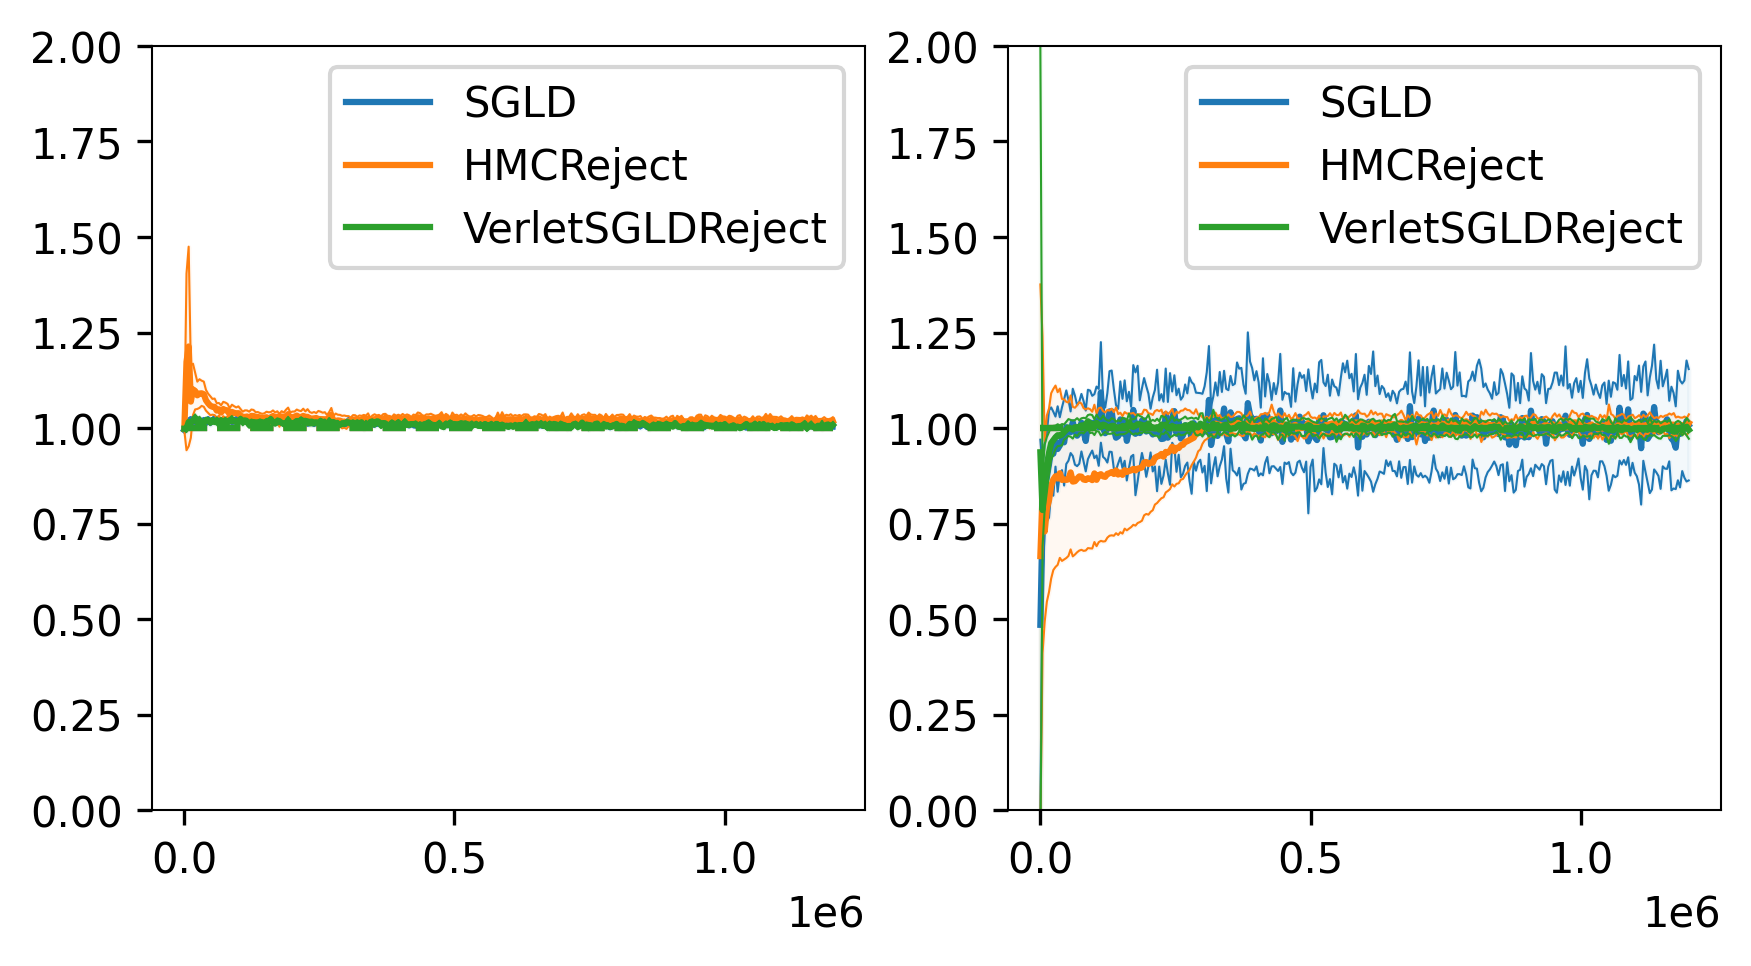

In [13]:
plt.rcParams.update({
    "font.family": "sans-serif",  # use serif/main font for text elements
    "text.usetex": False,     # use inline math for ticks
    "pgf.rcfonts": True,     # don't setup fonts from rc parameters
    "font.size": 10,
    "axes.linewidth": 0.5,
    "figure.dpi": 300,
})

fig_width_pt = 487.8225
inches_per_pt = 1.0/72.27               # Convert pt to inches
fig_width = fig_width_pt*inches_per_pt  # width in inches


temperature = 1.0
lr = 0.001

fig, axes = plt.subplots(1, 2, figsize=(fig_width, fig_width*1/2))
for inference in ["SGLD", "HMCReject", "VerletSGLDReject", ]:
    completed_df = full_df[(full_df["weight_prior"] == "gaussian") 
                           & (full_df["temperature"] == temperature)
                           & (full_df["inference"] == inference)
                           & (full_df["lr"] == lr)
                           & (full_df["cycles"] == 300)
                           & (full_df["load_samples"].isna())
                           & (full_df["the_dir"].apply(metrics_exist))]
    
    if not len(completed_df) == 1:
        print(completed_df)
        assert False
    
    with h5py.File(Path(completed_df["the_dir"].iloc[0])/"metrics.h5", "r", swmr=True) as metrics:
        #mask = ~np.isnan(metrics["est_temperature/all"])
        mask = (metrics["acceptance/is_sample"][:] == 1)
        plot.temperature_stderr(axes[0], metrics, "est_temperature", sizes, label=inference, legend=True, mask=mask)
        plot.temperature_stderr(axes[1], metrics, "est_config_temp", sizes, label=inference, legend=True, mask=mask)

axes[0].set_ylim(0, 2)
axes[1].set_ylim(0, 2)